In [1]:
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.compute as pc
import h5py
from src.generators import *
import time
from matplotlib import pyplot as plt
from typing import List
from tqdm import tqdm
np.random.seed(0)

In [12]:

N = list(range(10, 1010, 50))
D = 1
d = [(3, 32, 32), (3, 64, 64), (3, 128, 128),  
 (3, 256, 256), (3, 512, 512), (3, 640, 640), (3, 800, 800), (3, 1024, 1024)]

generator = F3()
for item in N:
    for res in tqdm(d):
        generator.create_dataset(item,res,D,f"outputs/f3_{item}_{res}_{D}")

In [2]:
N = [10,20,50]
D = 5
d = [(3, 32, 32),(3, 128, 128)]

In [3]:
generator = F3()
for item in N:
    for res in tqdm(d):
        generator.create_dataset(item,res,D,f"outputs/f3_{item}_{res}_{D}")

100%|██████████| 2/2 [00:06<00:00,  3.41s/it]


In [4]:
def is_leaf(name, node):
    """Check if a node is a dataset (leaf)."""
    return isinstance(node, h5py.Dataset)

def find_leaf_datasets(hdf5_file):
    """Find and return paths to all leaf datasets in an HDF5 file."""
    leaf_datasets = []

    # Traverse the HDF5 file
    hdf5_file.visititems(lambda name, node: leaf_datasets.append(name) if is_leaf(name, node) else None)
    
    return leaf_datasets

# D = 5 column wise

### Arrow 

In [5]:
from tqdm import tqdm
t_load_arrow_D5_c = []
t_manipulate_arrow_D5_c = []
iterations = 100

for item in N:
    tmp_load_res = []
    tmp_manipulate_res = []
    for res in d:
        tmp_load = []
        tmp_manipulate = []
        for j in tqdm(range(iterations)):
            st_time = time.time()
            ### LOADING ###
            table = pq.read_table(f'outputs/f3_{item}_{res}_{D}.parquet')
            ### ------- ###
            en_time = time.time()
            tmp_load.append(en_time - st_time)
            
            start_time = time.time()
            ### MANIPULATION ###
            
            oggetti = np.array(table.column("image_feature").chunk(0).values.field("image").to_pylist())
            image_numpy = np.frombuffer(oggetti, dtype=np.float64).reshape((-1,) + res)
            new_obj = np.transpose(image_numpy,axes=(0,3,2,1))   
            new_obj = np.square(new_obj)
            new_obj = np.exp(new_obj)
            new_obj = np.transpose(new_obj,axes=(0,3,2,1))
            ### ----------- ###
            end_time = time.time()
            tmp_manipulate.append(end_time-start_time)
        
        tmp_load_res.append(sum(tmp_load) / len(tmp_load))
        tmp_manipulate_res.append(sum(tmp_manipulate) / len(tmp_manipulate))
            
    t_load_arrow_D5_c.append(tmp_load_res)
    t_manipulate_arrow_D5_c.append(tmp_manipulate_res)

np.save("t_load_arrow_D1_c",t_load_arrow_D5_c)
np.save("t_manipulate_arrow_D1_c",t_manipulate_arrow_D5_c)

100%|██████████| 100/100 [00:42<00:00,  2.37it/s]


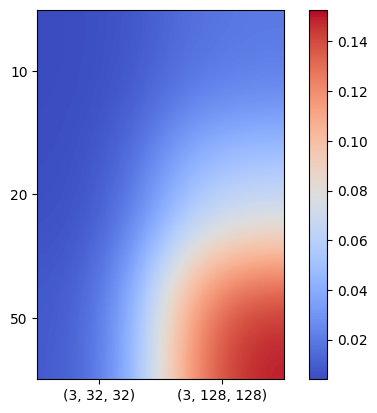

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
data = np.array(t_load_arrow_D5_c)
N_label = [str(item) for item in N]
d_label = [str(item) for item in d]
# Create the heatmap
plt.imshow(data, cmap='coolwarm', interpolation='gaussian')
plt.colorbar()

plt.xticks(ticks=np.arange(len(d_label)), labels=d_label)
plt.yticks(ticks=np.arange(len(N_label)), labels=N_label)

# Show the plot
plt.show()

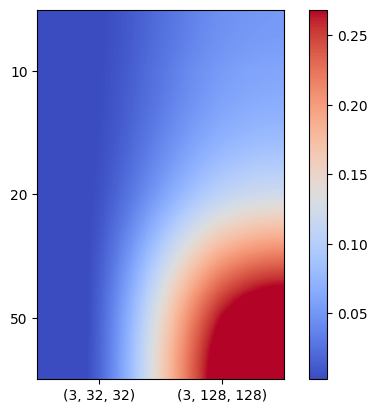

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
data = np.array(t_manipulate_arrow_D5_c)
N_label = [str(item) for item in N]
d_label = [str(item) for item in d]
# Create the heatmap
plt.imshow(data, cmap='coolwarm', interpolation='spline16') #interpolation --> spline16/gaussian
plt.colorbar()

plt.xticks(ticks=np.arange(len(d_label)), labels=d_label)
plt.yticks(ticks=np.arange(len(N_label)), labels=N_label)

# Show the plot
plt.show()

### HDF5

In [10]:
from tqdm import tqdm
t_load_hdf5_D5_c = []
t_manipulate_hdf5_D5_c = []
iterations = 100

for item in N:
    tmp_load_res = []
    tmp_manipulate_res = []
    for res in d:
        tmp_load = []
        tmp_manipulate = []
        for j in tqdm(range(iterations)):
            ### LOADING ###
            st_time = time.time()
            with h5py.File(f'outputs/f3_{item}_{res}_{D}.h5', 'r', driver="core") as f:
                en_time = time.time()
                ### ------ ###
                tmp_load.append(en_time - st_time)
                start_time = time.time()
                ### MANIPULATION ###
                def get_all_image_datasets():
                    image_datasets = []                
                    def visit_func(name, obj):
                        if isinstance(obj, h5py.Dataset) and obj.attrs["type"] == "image":
                            new_obj = np.transpose(obj)   
                            new_obj = np.square(new_obj)
                            new_obj = np.exp(new_obj)
                            new_obj = np.transpose(new_obj)
                            image_datasets.append(new_obj[:])
                
                    f.visititems(visit_func)
                    return np.array(image_datasets)
                image_ds = get_all_image_datasets()
                ### ----------- ###
                end_time = time.time()
                tmp_manipulate.append(end_time-start_time)
        tmp_load_res.append(sum(tmp_load) / len(tmp_load))
        tmp_manipulate_res.append(sum(tmp_manipulate) / len(tmp_manipulate))
    t_load_hdf5_D5_c.append(tmp_load_res)
    t_manipulate_hdf5_D5_c.append(tmp_manipulate_res)

np.save("t_load_hdf5_D5_c",t_load_hdf5_D5_c)
np.save("t_manipulate_hdf5_D5_c",t_manipulate_hdf5_D5_c)


100%|██████████| 100/100 [00:28<00:00,  3.53it/s]


In [11]:
image_ds

array([[[[1.00015846, 2.58093759, 2.30356342, ..., 1.36255682,
          2.10482467, 1.00009491],
         [1.19130458, 2.39483504, 1.25529465, ..., 1.23691597,
          2.44205126, 1.08943258],
         [1.08398154, 2.47363686, 1.06368406, ..., 1.0980918 ,
          1.0057757 , 2.51368533],
         ...,
         [1.0068897 , 1.0495926 , 1.03635079, ..., 1.50262948,
          2.37372858, 2.40542947],
         [1.04164013, 1.88188914, 1.00041878, ..., 2.37566203,
          1.20734595, 1.19455566],
         [1.24537   , 2.05113134, 1.77063721, ..., 1.21243391,
          2.19365117, 2.47430788]],

        [[1.00275861, 1.04744016, 2.35013028, ..., 1.22853351,
          1.67958557, 1.4410792 ],
         [1.09324731, 1.0001494 , 1.0891665 , ..., 1.95366815,
          1.43897592, 1.00122149],
         [1.15419502, 1.56771755, 1.04894695, ..., 2.00242689,
          2.34627201, 1.32463711],
         ...,
         [1.0612811 , 1.21404525, 2.65460073, ..., 1.52982765,
          1.00003263, 1.4

In [ ]:
with h5py.File(r"C:\Users\rober\OneDrive\Desktop\projects\benchmarks\outputs\f3_10_(3, 32, 32)_1.h5", mode="r") as f:
    print(f["example_0/image_feature/image"][:])
    print(find_leaf_datasets(f))

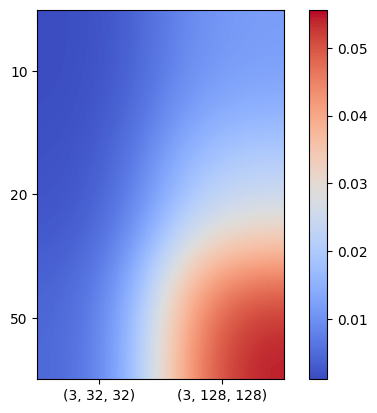

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
data = np.array(t_load_hdf5_D5_c)
N_label = [str(item) for item in N]
d_label = [str(item) for item in d]
# Create the heatmap
plt.imshow(data, cmap='coolwarm', interpolation='gaussian')
plt.colorbar()

plt.xticks(ticks=np.arange(len(d_label)), labels=d_label)
plt.yticks(ticks=np.arange(len(N_label)), labels=N_label)

# Show the plot
plt.show()

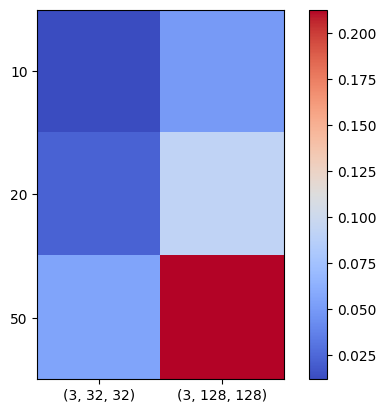

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
data = np.array(t_manipulate_hdf5_D5_c)
N_label = [str(item) for item in N]
d_label = [str(item) for item in d]
# Create the heatmap
plt.imshow(data, cmap='coolwarm', interpolation='nearest')
plt.colorbar()

plt.xticks(ticks=np.arange(len(d_label)), labels=d_label)
plt.yticks(ticks=np.arange(len(N_label)), labels=N_label)

# Show the plot
plt.show()

### Row wise D = 5

# Arrow

In [15]:
from tqdm import tqdm
t_load_arrow_D5_r = []
t_manipulate_arrow_D5_r = []
iterations = 100
selected_label = 1

for item in N:
    tmp_load_res = []
    tmp_manipulate_res = []
    for res in d:
        tmp_load = []
        tmp_manipulate = []
        for j in tqdm(range(iterations)):
            st_time = time.time()
            ### LOADING ###
            table = pq.read_table(f'outputs/f3_{item}_{res}_{D}.parquet')
            ### ------- ###
            en_time = time.time()
            tmp_load.append(en_time - st_time)
                
            start_time = time.time()
            ### MANIPULATION ###
            manipulated_images = []
            for k in range(item):
                if any( x == selected_label for x in table.column("image_feature").chunk(0)[k][0]["class_feature"].values.field("label").to_pylist()):  ## Indice di immagine deve variare nel framework
                    obj = table.column("image_feature").chunk(0)[k][0]["image"]
                    image_numpy = np.frombuffer(obj.as_buffer(), dtype=np.float64).reshape(res)
                    new_obj = np.transpose(image_numpy)   
                    new_obj = np.square(new_obj)
                    new_obj = np.exp(new_obj)
                    new_obj = np.transpose(new_obj)
                    manipulated_images.append(new_obj)
            ### ----------- ###
            end_time = time.time()
            tmp_manipulate.append(end_time-start_time)
                
        tmp_load_res.append(sum(tmp_load) / len(tmp_load))
        tmp_manipulate_res.append(sum(tmp_manipulate) / len(tmp_manipulate))

    t_load_arrow_D5_r.append(tmp_load_res)
    t_manipulate_arrow_D5_r.append(tmp_manipulate_res)

np.save("t_load_arrow_D5_r",t_load_arrow_D5_r)
np.save("t_manipulate_arrow_D5_r",t_manipulate_arrow_D5_r)

100%|██████████| 100/100 [00:35<00:00,  2.82it/s]


In [19]:
manipulated_images

[array([[[1.00015846, 2.58093759, 2.30356342, ..., 1.36255682,
          2.10482467, 1.00009491],
         [1.19130458, 2.39483504, 1.25529465, ..., 1.23691597,
          2.44205126, 1.08943258],
         [1.08398154, 2.47363686, 1.06368406, ..., 1.0980918 ,
          1.0057757 , 2.51368533],
         ...,
         [1.0068897 , 1.0495926 , 1.03635079, ..., 1.50262948,
          2.37372858, 2.40542947],
         [1.04164013, 1.88188914, 1.00041878, ..., 2.37566203,
          1.20734595, 1.19455566],
         [1.24537   , 2.05113134, 1.77063721, ..., 1.21243391,
          2.19365117, 2.47430788]],
 
        [[1.00275861, 1.04744016, 2.35013028, ..., 1.22853351,
          1.67958557, 1.4410792 ],
         [1.09324731, 1.0001494 , 1.0891665 , ..., 1.95366815,
          1.43897592, 1.00122149],
         [1.15419502, 1.56771755, 1.04894695, ..., 2.00242689,
          2.34627201, 1.32463711],
         ...,
         [1.0612811 , 1.21404525, 2.65460073, ..., 1.52982765,
          1.00003263, 1.

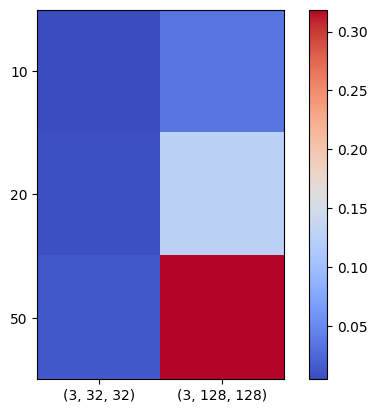

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
data = np.array(t_load_arrow_D5_r)
N_label = [str(item) for item in N]
d_label = [str(item) for item in d]
# Create the heatmap
plt.imshow(data, cmap='coolwarm', interpolation='nearest')
plt.colorbar()

plt.xticks(ticks=np.arange(len(d_label)), labels=d_label)
plt.yticks(ticks=np.arange(len(N_label)), labels=N_label)

# Show the plot
plt.show()

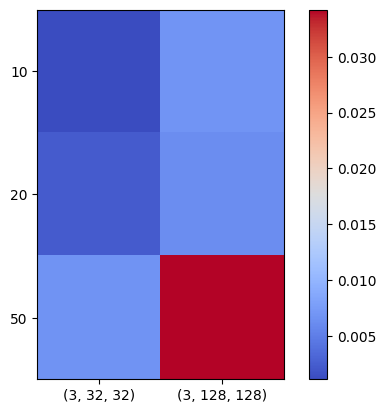

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
data = np.array(t_manipulate_arrow_D5_r)
N_label = [str(item) for item in N]
d_label = [str(item) for item in d]
# Create the heatmap
plt.imshow(data, cmap='coolwarm', interpolation='nearest')
plt.colorbar()

plt.xticks(ticks=np.arange(len(d_label)), labels=d_label)
plt.yticks(ticks=np.arange(len(N_label)), labels=N_label)

# Show the plot
plt.show()

# HDF5

In [23]:
from tqdm import tqdm
t_load_h5_D5_r = []
t_manipulate_h5_D5_r = []
iterations = 100
selected_label = 1

for item in N:
    tmp_load_res = []
    tmp_manipulate_res = []
    for res in d:
        tmp_load = []
        tmp_manipulate = []
        for j in tqdm(range(iterations)):
            ### LOADING ###
            st_time = time.time()
            with h5py.File(f'outputs/f3_{item}_{res}_{D}.h5', 'r', driver="core") as f:
                en_time = time.time()
                ### ------ ###
                tmp_load.append(en_time - st_time)
                start_time = time.time()
                ### MANIPULATION ###
                def get_all_image_datasets():
                    image_datasets = []                
                    def visit_func(name, obj):
                        if isinstance(obj, h5py.Dataset) and obj.attrs["type"] == "image" and obj.attrs["label"] == selected_label :
                            im_obj = obj[:]
                            new_obj = np.transpose(im_obj)   
                            new_obj = np.square(new_obj)
                            new_obj = np.exp(new_obj)
                            new_obj = np.transpose(new_obj)
                            image_datasets.append(new_obj)
                    f.visititems(visit_func)
                    return image_datasets
                image_ds = get_all_image_datasets()
                ### ----------- ###
                end_time = time.time()
                tmp_manipulate.append(end_time-start_time)
        tmp_load_res.append(sum(tmp_load) / len(tmp_load))
        tmp_manipulate_res.append(sum(tmp_manipulate) / len(tmp_manipulate))
    t_load_h5_D5_r.append(tmp_load_res)
    t_manipulate_h5_D5_r.append(tmp_manipulate_res)

np.save("t_load_h5_D5_r",t_load_h5_D5_r)
np.save("t_manipulate_h5_D5_r",t_manipulate_h5_D5_r)


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


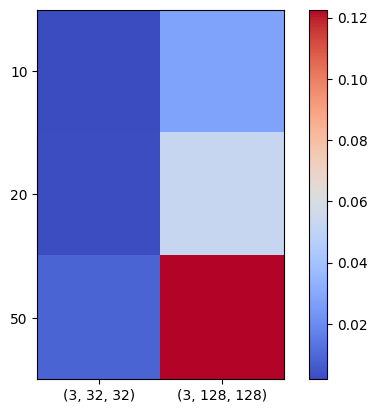

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
data = np.array(t_load_h5_D5_r)
N_label = [str(item) for item in N]
d_label = [str(item) for item in d]
# Create the heatmap
plt.imshow(data, cmap='coolwarm', interpolation='nearest')
plt.colorbar()

plt.xticks(ticks=np.arange(len(d_label)), labels=d_label)
plt.yticks(ticks=np.arange(len(N_label)), labels=N_label)

# Show the plot
plt.show()

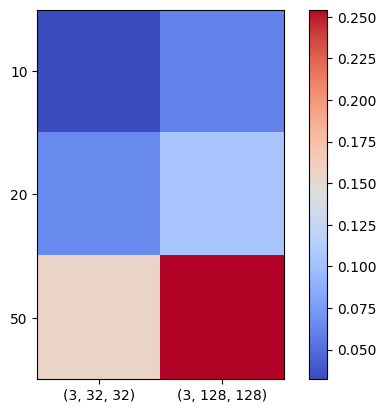

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
data = np.array(t_manipulate_h5_D5_r)
N_label = [str(item) for item in N]
d_label = [str(item) for item in d]
# Create the heatmap
plt.imshow(data, cmap='coolwarm', interpolation='nearest')
plt.colorbar()

plt.xticks(ticks=np.arange(len(d_label)), labels=d_label)
plt.yticks(ticks=np.arange(len(N_label)), labels=N_label)

# Show the plot
plt.show()

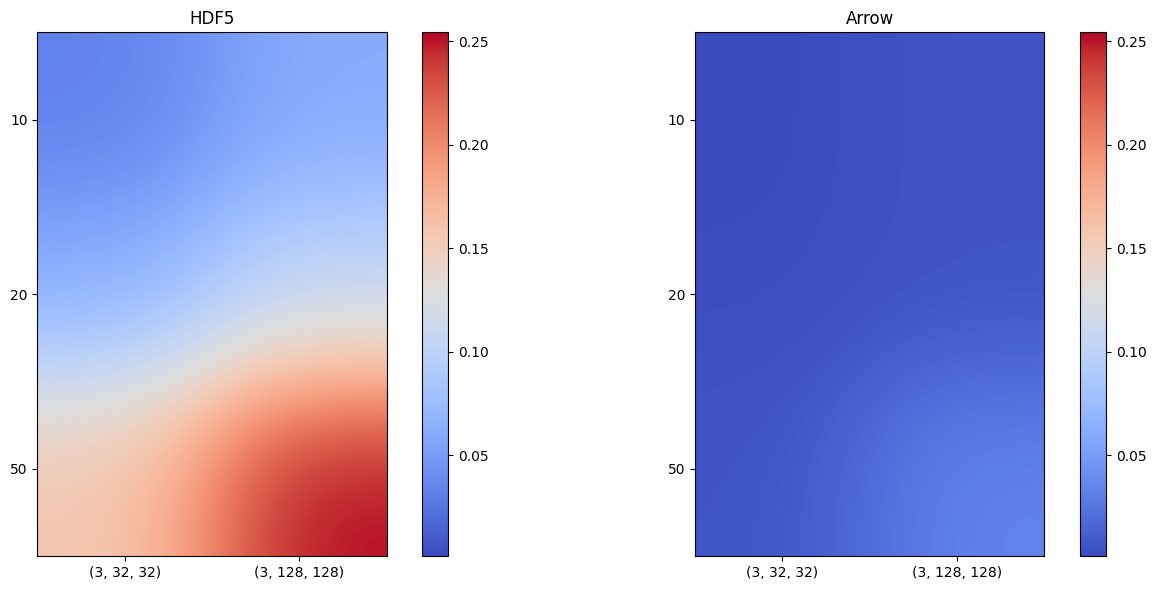

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Sample data
data1 = np.array(t_manipulate_h5_D5_r)
data2 = np.array(t_manipulate_arrow_D5_r)
N_label = [str(item) for item in N]
d_label = [str(item) for item in d]

# Create a figure with 2 subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

vmin = min(data1.min(), data2.min())
vmax = max(data1.max(), data2.max())
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# First heatmap
cax1 = ax[0].imshow(data1, cmap='coolwarm', interpolation='gaussian', norm=norm)
ax[0].set_title('HDF5')
fig.colorbar(cax1, ax=ax[0], orientation='vertical')
ax[0].set_xticks(ticks=np.arange(len(d_label)), labels=d_label)
ax[0].set_yticks(ticks=np.arange(len(N_label)), labels=N_label)

# Second heatmap
cax2 = ax[1].imshow(data2, cmap='coolwarm', interpolation='gaussian',norm=norm)
ax[1].set_title('Arrow')
fig.colorbar(cax2, ax=ax[1], orientation='vertical')
ax[1].set_xticks(ticks=np.arange(len(d_label)), labels=d_label)
ax[1].set_yticks(ticks=np.arange(len(N_label)), labels=N_label)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()
